# Analysis of user behavior in a food product's sale mobile application

## Introduction

In the upcoming project, our task is to analyze the behavior of users in a food product's sale mobile application.
We will analyze data that contains information about events that users made in the application, as well as examine the results of an A/A/B test conducted by marketers.
Our research will include the following steps:
1. We will study the sales funnel.
2. Find out how users conduct a purchase.
3. Make an analysis of the number of users who made a purchase. Find out how many were eliminated on the previous steps, and on which particular steps.
4. Explore the results of the A/A/B experiment.
5. We will decide whether to stop or continue the experiment.
6. Draw conclusions based on the conducted study.

## Get familiar with data

### Import of libraries

In [82]:
import pandas as pd
import math as mth
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px 
from plotly import graph_objects as go

We imported necessary libraries.

### Import of datasets

In [83]:
try:
    data = pd.read_csv('C:/Praktikum/food_app_project/logs_exp.csv',sep='\t', engine='python') 
except: 
      data = pd.read_csv('/datasets/logs_exp.csv',sep='\t', engine='python')

In [84]:
def data_first_look(data):
    print('Main information:')
    print()
    data.info()
    print()
    print('The first 10 rows of the data:')
    display(data.head())
    print()
    print('Main characteristics of the data:')
    display(data.describe())
    print()
    print('The amount of duplicates in data is', data.duplicated().sum())
    
data_first_look(data)    

Main information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB

The first 10 rows of the data:


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248



Main characteristics of the data:


,DeviceIDHash,EventTimestamp,ExpId
count,2.441260e+05,2.441260e+05,244126.000000
mean,4.627568e+18,1.564914e+09,247.022296
std,2.642425e+18,1.771343e+05,0.824434
min,6.888747e+15,1.564030e+09,246.000000
25%,2.372212e+18,1.564757e+09,246.000000
50%,4.623192e+18,1.564919e+09,247.000000
75%,6.932517e+18,1.565075e+09,248.000000
max,9.222603e+18,1.565213e+09,248.000000



The amount of duplicates in data is 413


In [85]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


**We imported the files and looked at the basic information about the dataset. We divided dataset into 4 column: event data, user id, event date, and group id in the a/b test.**

### Data preprocessing

In [86]:
data.rename({'EventName':'event_name', 'DeviceIDHash':'user_id', 'EventTimestamp':'event_date', 'ExpId':'group_id'}, axis=1, inplace = True)
# renamed the columns

In [87]:
data['event_date'] = pd.to_datetime(data['event_date'], unit='s') # transfigured date from unix time format
data['date_only'] = data['event_date'].dt.date
data['date_only'] = pd.to_datetime(data['date_only']) # made a separate column for date
data['user_id'] = data['user_id'].astype(object)
data['group_id'] = data['group_id'].astype(object) # changed data format

In [88]:
data.info()
data.head() # check if previous steps worked out

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   user_id     244126 non-null  object        
 2   event_date  244126 non-null  datetime64[ns]
 3   group_id    244126 non-null  object        
 4   date_only   244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(3)
memory usage: 9.3+ MB


,event_name,user_id,event_date,group_id,date_only
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


We renamed the columns, changed the data format, converted the timestamp format to date and time, and created a separate column with the date.

In [89]:
data.duplicated().sum() # checked for duplicated
data.drop_duplicates() # found 413 and deleted them

,event_name,user_id,event_date,group_id,date_only
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


In [90]:
data['event_name'].value_counts() 

MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: event_name, dtype: int64

We looked at unique values in the columns with the group_id and event_id and counted their number. There are no gaps in these columns.

In [91]:
data['group_id'].value_counts()

248    85747
246    80304
247    78075
Name: group_id, dtype: int64

**Groups are distributed by number not quite evenly, there are 5-7 thousand more users in the experimental group than in the control groups. We will check in the next section just how critical it is.
At this point, data preprocessing can be considered complete and we can proceed to examine the data for correctness.**

## Examine the data for correctness

In this section, we will check whether the provided data is correct and whether we can freely work with it.

In [92]:
data.groupby('user_id', as_index=False)\
    .agg({'group_id':'nunique'})\
    .query("group_id>=2")\
    .shape

(0, 2)

We checked if there are users who participated in two or all three groups - there are none of these.

In [93]:
print('Total number of events in the log', data['event_name'].count())
print('The number of unique users', data['user_id'].nunique())
print('The average number of events per user','{0:.2f}'.format(data['event_name'].count()/data['user_id'].nunique()))

Total number of events in the log 244126
The number of unique users 7551
The average number of events per user 32.33


In [94]:
print('The minimum date in the log', data['date_only'].min()) 
print('The maximum date in the log', data['date_only'].max())

The minimum date in the log 2019-07-25 00:00:00
The maximum date in the log 2019-08-07 00:00:00


We calculated the average number of events per user and checked what period we have data for.

In [95]:
data.groupby('date_only').agg({'event_name':'count'})

,event_name
date_only,
2019-07-25,9
2019-07-26,31
2019-07-27,55
2019-07-28,105
2019-07-29,184
2019-07-30,413
2019-07-31,2031
2019-08-01,36229
2019-08-02,35606


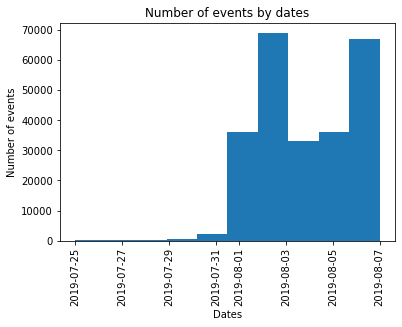

In [96]:
data['date_only'].hist(grid=False)
plt.xticks(rotation=90)
plt.title("Number of events by dates")
plt.xlabel("Dates")
plt.ylabel("Number of events")
plt.show()

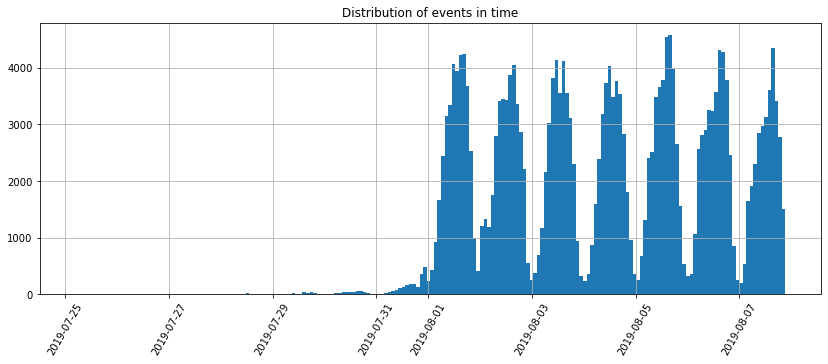

In [97]:
data['event_date'].hist(bins=200, figsize=(14, 5)).set_title('Distribution of events in time')
plt.xticks(rotation=60);

In [98]:
data_date = data.query('date_only == "2019-07-31"')

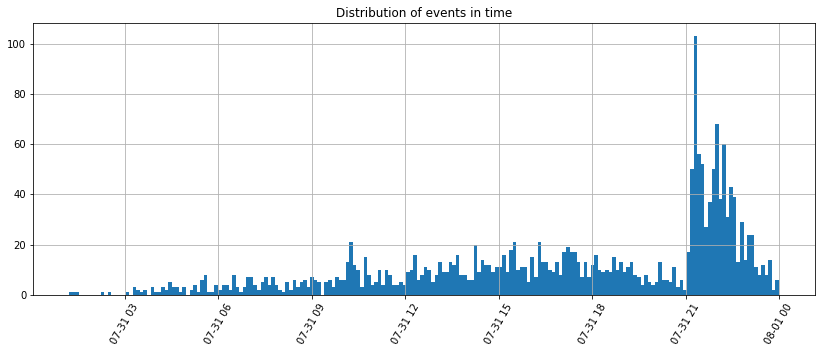

In [99]:
data_date['event_date'].hist(bins=200, figsize=(14, 5)).set_title('Distribution of events in time')
plt.xticks(rotation=60);

We can see that, despite the fact that our minimal data is July 25, a significant amount of events appear only in the evening - more precisely from 21:00 of July 31. Therefore we can analyze the data only for a week.
We will remove the "extra" data and see how it affects the whole picture.

In [100]:
data_cleaned = data[(data['event_date'] >= '2019-07-25 21:00:00')] # remove data from previous days
print('The total number of events in the cleaned dataset', data_cleaned['event_name'].count()) 
print('The number of unique users in cleaned dataset', data_cleaned['user_id'].nunique())
print('The average number of events per user in cleaned dataset','{0:.2f}'.format(data_cleaned['event_name'].count()/data_cleaned['user_id'].nunique()))

The total number of events in the cleaned dataset 244117
The number of unique users in cleaned dataset 7551
The average number of events per user in cleaned dataset 32.33


In [101]:
print('Percentage of reducted users', '{0:.3f}'.format(100 - (data_cleaned['user_id'].nunique()/data['user_id'].nunique()) * 100), '%')
print('Percentage of reducted events', '{0:.3f}'.format(100 - (data_cleaned['event_name'].count()/data['event_name'].count()) * 100), '%')

Percentage of reducted users 0.000 %
Percentage of reducted events 0.004 %


After cleaning data for days with few or no events, we didn’t lose any users and only 0.4% of events.

In [102]:
data_cleaned['group_id'].value_counts()

248    85743
246    80300
247    78074
Name: group_id, dtype: int64

After cleaning the dataset, we still have events from all three groups in almost the same proportions as before it.

**During the process of analyzing the data for correctness, we found that, despite the fact that we have data on events for two weeks, 80% of the events occur in the second week. So we cleaned the data, leaving only the events from 07/31/2017 from 21:00 to 08/07/2017. We checked that all three user groups remained in this data and that they remained distributed in the same proportion as they were. In the next section, we will analyze the event’s funnel.**

## Analysis of event’s funnel

In this section, we will analyze the events funnel. We will consider what events we have in the log, in what order they occur, and at what stage we lose the majority of users.

In [103]:
data_cleaned['event_name'].value_counts() # counted the number of events

MainScreenAppear           119201
OffersScreenAppear          46824
CartScreenAppear            42729
PaymentScreenSuccessful     34311
Tutorial                     1052
Name: event_name, dtype: int64

There are five types of events in total in our data set: the user opened the application (119201 times), the user went to the shopping basket (46824), the user was prompted to enter the card’s details (42729), the user made a payment (34311), the user read the instruction (1052).
An event with instruction can not be added to the event funnel since it is optional according to numbers.

In [104]:
data_cleaned['user_id'].nunique() # counted total amount of users

7551

In [105]:
data_events = data_cleaned.groupby('event_name').agg({'user_id':'nunique',}).sort_values(by='user_id', ascending=False)
data_events.style

,user_id
event_name,
MainScreenAppear,7439
OffersScreenAppear,4613
CartScreenAppear,3749
PaymentScreenSuccessful,3547
Tutorial,847


We sorted the events by the number of users who made them. 7439 users opened the application, 4613 users went to the shopping cart, 3749 users entered the card data, 3547 users paid for the purchase, and 847 users watched the instructions.

In [106]:
data_events['share'] = ((data_events['user_id'] / data_cleaned['user_id'].nunique()) * 100).round()
data_events

,user_id,share
event_name,,
MainScreenAppear,7439,99.0
OffersScreenAppear,4613,61.0
CartScreenAppear,3749,50.0
PaymentScreenSuccessful,3547,47.0
Tutorial,847,11.0


We calculated the share of users who completed each event. The application was launched by 99% of users, 61% went to a shopping cart, 50% started entering credit card's details, 47% made a payment, and 11% viewed the training.

In [107]:
fig = go.Figure(
    go.Funnel(
        y=[
            'Launched the app',
            'Went to a shopping cart',
            'Entered credit card data',
            'Made a purchase',
        ],
        x=[7439, 4613, 3739, 3547],
    )
)
fig.show() 

**As we can see on the graph, we lost most of the users during the transition from launching the application to the shopping cart. Only 62% of users move between these steps. At further steps, the transitions are less noticeable: 81.1% of users go from the payment window to entering card data, and 94.9% of users go from entering card data to the successful payment window.
In total, 47.7% of users make it from launching the app to successful payment.**

## A/A/B test analysis

In this part of the project, we will analyze the conducted A/A/B testing. We will consider the correctness of the division’s users between groups, evaluate the results of the A / A test, and check the level of statistical significance of differences between the control and experimental groups.

In [108]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244117 entries, 9 to 244125
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244117 non-null  object        
 1   user_id     244117 non-null  object        
 2   event_date  244117 non-null  datetime64[ns]
 3   group_id    244117 non-null  object        
 4   date_only   244117 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(3)
memory usage: 11.2+ MB


In [109]:
data_cleaned.groupby('group_id').agg({'user_id': 'nunique'}) # grouped by the number of users in each group

,user_id
group_id,
246,2489
247,2520
248,2542


We checked how many users are in each group. Users are divided almost evenly, the difference does not exceed 31 users, which does not exceed 0.1% of all users.

In [110]:
data_group_A0 = data_cleaned.query('group_id == 246') # we split the dataset into three separate groups in order to compare them

In [111]:
data_group_A1 = data_cleaned.query('group_id == 247')

In [112]:
data_group_B = data_cleaned.query('group_id == 248')

Firstly we will test the hypothesis of equal shares for the control groups. We will write a function to check if the difference between the events in the control groups is statistically significant.
Our null hypothesis is that the change in the font of the app did not affect the user’s behavior. 
We will consider whether the change in the user’s behavior is significant enough for rejecting the null hypothesis.
Our alternative hypothesis is that the change of the fond affects user behavior.


In [113]:
data_events_A0 = data_group_A0.groupby('event_name').agg({'user_id':'nunique',}).sort_values(by='user_id', ascending=False)
data_events_A0['share'] = (data_events_A0['user_id'] / data_group_A0['user_id'].nunique()*100).round()
data_events_A0.style # we counted the number of users in each group

,user_id,share
event_name,,
MainScreenAppear,2456,99.000000
OffersScreenAppear,1545,62.000000
CartScreenAppear,1270,51.000000
PaymentScreenSuccessful,1202,48.000000
Tutorial,279,11.000000


In [114]:
data_events_A1 = data_group_A1.groupby('event_name').agg({'user_id':'nunique',}).sort_values(by='user_id', ascending=False)
data_events_A1['share'] = (data_events_A1['user_id'] / data_group_A1['user_id'].nunique()*100).round()
data_events_A1.style

,user_id,share
event_name,,
MainScreenAppear,2482,98.000000
OffersScreenAppear,1530,61.000000
CartScreenAppear,1240,49.000000
PaymentScreenSuccessful,1160,46.000000
Tutorial,286,11.000000


We counted the number of users who completed each action in both groups.

In [115]:
print(data_group_A0['user_id'].nunique(), data_group_A1['user_id'].nunique()) 
# check the amount of unique users in each group

2489 2520


Before testing the hypothesis, we should determine the level of significance. Since we have to do three comparisons, the probability of getting a false-positive result is 14%. Therefore, we will use the Bonferroni correction to reduce the probability of a Type II error.

In [116]:
def stat_difference(data_1, data_2, event): # function for counting the statistical significance with Bonferroni correction
    alpha = 0.05 
    bonferroni_alpha = alpha / 3
    leads_0 = data_1['user_id'].nunique()
    leads_1 = data_2['user_id'].nunique()
    event == event
    purchases_0 = data_1.query('event_name == @event')['user_id'].nunique()
    purchases_1 = data_2.query('event_name == @event')['user_id'].nunique()
    p1 = purchases_0/leads_0
    p2 = purchases_1/leads_1
    p_combined = (purchases_0 + purchases_1) / (leads_0 + leads_1)
    difference = p1 - p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/leads_0 + 1/leads_1))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-value: ', '{0:.3f}'.format(p_value))
    if p_value < bonferroni_alpha:
        print('We are rejecting the null hypothesis: there is a significant difference between the groups.')
    else:
        print('It is not possible to reject the null hypothesis, there is no reason to find the groups different.'
    )
print(stat_difference(data_group_A0, data_group_A1, "MainScreenAppear"))
print(stat_difference(data_group_A0, data_group_A1, "OffersScreenAppear"))
print(stat_difference(data_group_A0, data_group_A1, "CartScreenAppear"))
print(stat_difference(data_group_A0, data_group_A1, "PaymentScreenSuccessful"))
print(stat_difference(data_group_A0, data_group_A1, "Tutorial"))

p-value:  0.586
It is not possible to reject the null hypothesis, there is no reason to find the groups different.
None
p-value:  0.323
It is not possible to reject the null hypothesis, there is no reason to find the groups different.
None
p-value:  0.198
It is not possible to reject the null hypothesis, there is no reason to find the groups different.
None
p-value:  0.109
It is not possible to reject the null hypothesis, there is no reason to find the groups different.
None
p-value:  0.876
It is not possible to reject the null hypothesis, there is no reason to find the groups different.
None


Based on the comparison made between the two groups, we can see that in the control groups there is no difference in the number of users who committed events.
We can conclude that the division into groups was made correctly.
In the next part, we will compare the first control group with the experimental group.


In [117]:
print(stat_difference(data_group_A0, data_group_B, "MainScreenAppear"))
print(stat_difference(data_group_A0, data_group_B, "OffersScreenAppear"))
print(stat_difference(data_group_A0, data_group_B, "CartScreenAppear"))
print(stat_difference(data_group_A0, data_group_B, "PaymentScreenSuccessful"))
print(stat_difference(data_group_A0, data_group_B, "Tutorial"))

p-value:  0.398
It is not possible to reject the null hypothesis, there is no reason to find the groups different.
None
p-value:  0.253
It is not possible to reject the null hypothesis, there is no reason to find the groups different.
None
p-value:  0.105
It is not possible to reject the null hypothesis, there is no reason to find the groups different.
None
p-value:  0.234
It is not possible to reject the null hypothesis, there is no reason to find the groups different.
None
p-value:  0.896
It is not possible to reject the null hypothesis, there is no reason to find the groups different.
None


There are also no differences between the first control group and the experimental group.

In [118]:
print(stat_difference(data_group_A1, data_group_B, "MainScreenAppear"))
print(stat_difference(data_group_A1, data_group_B, "OffersScreenAppear"))
print(stat_difference(data_group_A1, data_group_B, "CartScreenAppear"))
print(stat_difference(data_group_A1, data_group_B, "PaymentScreenSuccessful"))
print(stat_difference(data_group_A1, data_group_B, "Tutorial"))

p-value:  0.763
It is not possible to reject the null hypothesis, there is no reason to find the groups different.
None
p-value:  0.878
It is not possible to reject the null hypothesis, there is no reason to find the groups different.
None
p-value:  0.741
It is not possible to reject the null hypothesis, there is no reason to find the groups different.
None
p-value:  0.676
It is not possible to reject the null hypothesis, there is no reason to find the groups different.
None
p-value:  0.773
It is not possible to reject the null hypothesis, there is no reason to find the groups different.
None


There are also no differences between the second control group and the experimental group.
Out of interest, we check what happens if if we don’t apply the Bonferroni correction:

In [119]:
def stat_difference_no_bonferroni(data_1, data_2, event): # function for counting the statistical significance without Bonferroni correction
    alpha = 0.05 
    leads_0 = data_1['user_id'].nunique()
    leads_1 = data_2['user_id'].nunique()
    event == event
    purchases_0 = data_1.query('event_name == @event')['user_id'].nunique()
    purchases_1 = data_2.query('event_name == @event')['user_id'].nunique()
    p1 = purchases_0/leads_0
    p2 = purchases_1/leads_1
    p_combined = (purchases_0 + purchases_1) / (leads_0 + leads_1)
    difference = p1 - p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/leads_0 + 1/leads_1))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-value:', '{0:.3f}'.format(p_value))
    if p_value < alpha:
        print('We are rejecting the null hypothesis: there is a significant difference between the groups.')
    else:
        print('It is not possible to reject the null hypothesis, there is no reason to find the groups different.'
    )

In [120]:
print(stat_difference_no_bonferroni(data_group_A0, data_group_A1, "MainScreenAppear"))
print(stat_difference_no_bonferroni(data_group_A0, data_group_A1, "OffersScreenAppear"))
print(stat_difference_no_bonferroni(data_group_A0, data_group_A1, "CartScreenAppear"))
print(stat_difference_no_bonferroni(data_group_A0, data_group_A1, "PaymentScreenSuccessful"))
print(stat_difference_no_bonferroni(data_group_A0, data_group_A1, "Tutorial"))

p-value: 0.586
It is not possible to reject the null hypothesis, there is no reason to find the groups different.
None
p-value: 0.323
It is not possible to reject the null hypothesis, there is no reason to find the groups different.
None
p-value: 0.198
It is not possible to reject the null hypothesis, there is no reason to find the groups different.
None
p-value: 0.109
It is not possible to reject the null hypothesis, there is no reason to find the groups different.
None
p-value: 0.876
It is not possible to reject the null hypothesis, there is no reason to find the groups different.
None


In [121]:
print(stat_difference_no_bonferroni(data_group_A0, data_group_B, "MainScreenAppear"))
print(stat_difference_no_bonferroni(data_group_A0, data_group_B, "OffersScreenAppear"))
print(stat_difference_no_bonferroni(data_group_A0, data_group_B, "CartScreenAppear"))
print(stat_difference_no_bonferroni(data_group_A0, data_group_B, "PaymentScreenSuccessful"))
print(stat_difference_no_bonferroni(data_group_A0, data_group_B, "Tutorial"))

p-value: 0.398
It is not possible to reject the null hypothesis, there is no reason to find the groups different.
None
p-value: 0.253
It is not possible to reject the null hypothesis, there is no reason to find the groups different.
None
p-value: 0.105
It is not possible to reject the null hypothesis, there is no reason to find the groups different.
None
p-value: 0.234
It is not possible to reject the null hypothesis, there is no reason to find the groups different.
None
p-value: 0.896
It is not possible to reject the null hypothesis, there is no reason to find the groups different.
None


In [122]:
print(stat_difference_no_bonferroni(data_group_A1, data_group_B, "MainScreenAppear"))
print(stat_difference_no_bonferroni(data_group_A1, data_group_B, "OffersScreenAppear"))
print(stat_difference_no_bonferroni(data_group_A1, data_group_B, "CartScreenAppear"))
print(stat_difference_no_bonferroni(data_group_A1, data_group_B, "PaymentScreenSuccessful"))
print(stat_difference_no_bonferroni(data_group_A1, data_group_B, "Tutorial"))

p-value: 0.763
It is not possible to reject the null hypothesis, there is no reason to find the groups different.
None
p-value: 0.878
It is not possible to reject the null hypothesis, there is no reason to find the groups different.
None
p-value: 0.741
It is not possible to reject the null hypothesis, there is no reason to find the groups different.
None
p-value: 0.676
It is not possible to reject the null hypothesis, there is no reason to find the groups different.
None
p-value: 0.773
It is not possible to reject the null hypothesis, there is no reason to find the groups different.
None


Even without the Bonferroni correction, there is no statistically significant difference between the groups.

**Based on the A/A/B test analysis, we can conclude that there is no statistically significant difference between the three groups.**

## Conclusions

In this project, we had two tasks:
1. Find out how users of the mobile app behave.
2. To examine the results of an A/A/B test.

During the data preprocessing, we found out that we have data only for 7 days.
Before this date, the minimum number of events was logged. 
Therefore we deleted the data for the first 7 days and then worked on the cleaned data.

We studied the sales funnel.

In this application, the funnel consists of four events: the user launches the application, then goes to the shopping cart page, then to the credit card details entry form, and the last step is the opening of the successful payment screen.

A significant part of users gets lost during the transition between launching the application to the shopping cart. Only 62% of users move through these steps.

We can assume that the reason for these disappointing numbers is that the user did not find the desired product and did not add anything to the cart.

At further steps, the transitions are less noticeable: 81.3% of users go from the payment screen to entering credit card details, and 95% of users go from entering credit card details to the screen of successful payment.

In total, 47.7% of users go from opening the application to a successful payment

Then, we conducted a statistical analysis and compared the number of users who made a particular event in two control groups and one experimental group.

We checked that the division between groups was done correctly. Then, we compared the shares of users who made particular events.
We did not find a statistically significant difference between groups in any of the comparisons using the Bonferroni correction.

Without the Bonferroni correction, however, there is no difference between the groups either.

**Based on the analysis of the A/A/B test, it can be concluded that there is no statistically significant difference between the three groups.**

The test can be stopped, since in almost all tests the difference between the p-value and significance level is quite large, so the situation is unlikely to change.

**We draw the following conclusions:**

**1) We should find the reason for losing users during the transition from launching the app to the shopping cart.**

**2. Changing the font in the application does not affect the user’s behavior in any way.**
